## Comparing Linear sweeps and random bursts at low amplitude
The ability of low amplitude forcing functions to predict dopamine based on shape is compared.

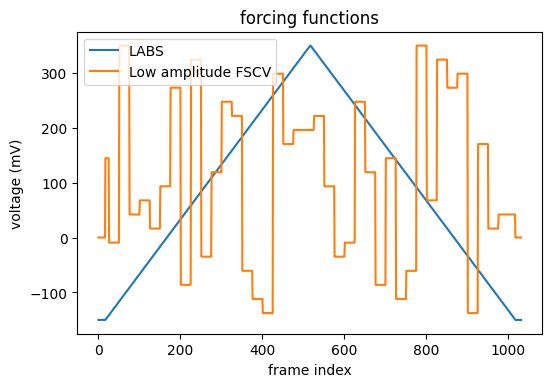

In [1]:
# Import Packages
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import voltammetry
import matplotlib as mpl
from sklearn.metrics import r2_score
from glmnet_python import cvglmnetCoef
from recordclass import recordclass
# load data
low_FSCV_data = h5py.File('FSCV_Low_Amplitude_preproc.h5','r')
LABS_data = h5py.File('LABS_preproc.h5','r')
# plot forcing functions
plt.figure(dpi=100)
plt.plot(low_FSCV_data['header/CMD'])
plt.plot(LABS_data['header/CMD'])
plt.legend({'Low amplitude FSCV','LABS'})
plt.title('forcing functions')
plt.xlabel('frame index')
plt.ylabel('voltage (mV)');

In [2]:
# create recordclass structures as inputs for model
low_FSCV_training = recordclass('low_FSCV_training', 'vgrams, labels')
low_FSCV_testing = recordclass('low_FSCV_testing', 'vgrams, labels')

LABS_training = recordclass('LABS_training', 'vgrams, labels')
LABS_testing = recordclass('LABS_testing', 'vgrams, labels')

low_FSCV_training.vgrams = low_FSCV_data['training/vgrams']
low_FSCV_training.labels = low_FSCV_data['training/labels']
low_FSCV_testing.vgrams = low_FSCV_data['testing/vgrams']
low_FSCV_testing.labels = low_FSCV_data['testing/labels']

LABS_training.vgrams = LABS_data['training/vgrams']
LABS_training.labels = LABS_data['training/labels']
LABS_testing.vgrams = LABS_data['testing/vgrams']
LABS_testing.labels = LABS_data['testing/labels']

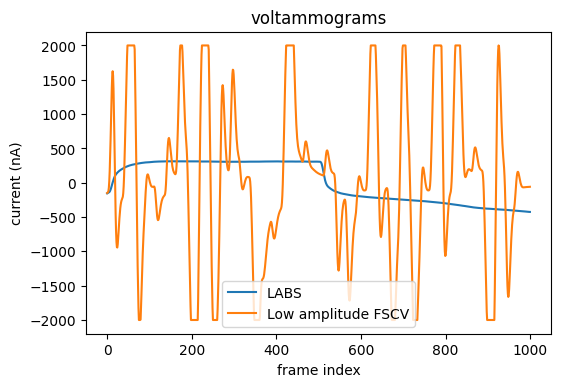

In [3]:
plt.figure(dpi=100)
plt.plot(low_FSCV_training.vgrams[0,:])
plt.plot(LABS_training.vgrams[0,:])
plt.legend({'Low amplitude FSCV','LABS'})
plt.title('voltammograms')
plt.xlabel('frame index')
plt.ylabel('current (nA)');

In [4]:
# run calibrations for low amplitude FSCV
max_core = 8 # maxmum number of corest that can be used in parallel by machine for training
idx = np.squeeze(np.where(low_FSCV_training.labels[:,1]==0)) # only interested in Dopamine data
low_FSCV_training.labels = low_FSCV_training.labels[idx,:]
low_FSCV_training.vgrams = low_FSCV_training.vgrams[idx,:]

#bestAlpha = voltammetry.best_alpha(low_FSCV_training)
bestAlpha = 0.8

low_FSCV_cvFit = voltammetry.train_analyte(low_FSCV_training, alpha=bestAlpha,parallel=max_core)
# predicting concentration using regression - dopamine results
idx = np.squeeze(np.where(low_FSCV_testing.labels[:,1]==0)) # only interested in Dopamine data
low_FSCV_testing.labels = low_FSCV_testing.labels[idx,:]
low_FSCV_testing.vgrams = low_FSCV_testing.vgrams[idx,:]

low_FSCV_predictions = voltammetry.test_analyte(low_FSCV_testing, low_FSCV_cvFit)
low_FSCV_stats = voltammetry.calcStepStats(0, low_FSCV_predictions, low_FSCV_testing.labels)


TRAINING COMPLETE  1735.682  seconds. 



In [5]:
# run calibrations for LABS
max_core = 8 # maxmum number of corest that can be used in parallel by machine for training
idx = np.squeeze(np.where(LABS_training.labels[:,1]==0)) # only interested in Dopamine data
LABS_training.labels = LABS_training.labels[idx,:]
LABS_training.vgrams = LABS_training.vgrams[idx,:]

#bestAlpha = voltammetry.best_alpha(LABS_data.training)
bestAlpha = 0.9
# predict concentration using regression - dopamine results
idx = np.squeeze(np.where(LABS_testing.labels[:,1]==0)) # only interested in Dopamine data
LABS_testing.labels = LABS_testing.labels[idx,:]
LABS_testing.vgrams = LABS_testing.vgrams[idx,:]

LABS_cvFit = voltammetry.train_analyte(LABS_training, alpha=bestAlpha,parallel=max_core)
LABS_predictions = voltammetry.test_analyte(LABS_testing, LABS_cvFit)

TRAINING COMPLETE  1994.857  seconds. 



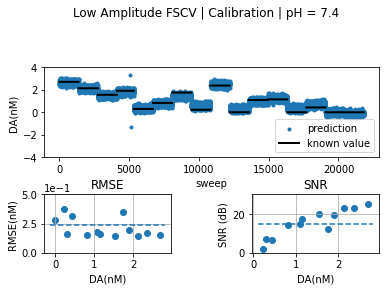

In [26]:
# dopamine results (pH 7.4)
# Generate predictions, plot results for low FSCV
chemIx = 0
predictions = low_FSCV_predictions
labels = low_FSCV_testing.labels
idx = np.squeeze(np.where(low_FSCV_testing.labels[:,2]==7.4))

t = np.arange(len(labels))
stats = voltammetry.calcStepStats(chemIx, predictions[idx,:], labels[idx,:])

[calFig,ax1,ax2,ax3] = voltammetry.plot_Calibration(t, predictions[idx,:], labels[idx,:], ['DA','NE','pH'], chemIx, stats)
ax1.set_ylim(-4.00,4.000)
ax2.set_ylim(0,0.5)
ax3.set_ylim(0,30.000)
plt.suptitle('Low Amplitude FSCV | Calibration | pH = 7.4');


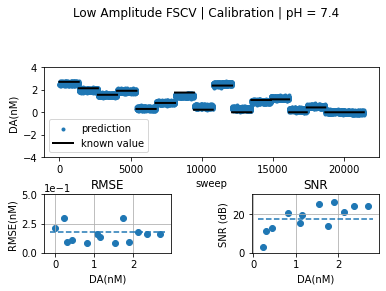

In [27]:
# dopamine results (pH 7.4)
# Generate predictions, plot results for LABS
chemIx = 0
predictions = LABS_predictions
labels = LABS_testing.labels
idx = np.squeeze(np.where(LABS_testing.labels[:,2]==7.4))

t = np.arange(len(labels))
stats = voltammetry.calcStepStats(chemIx, predictions[idx,:], labels[idx,:])

[calFig,ax1,ax2,ax3] = voltammetry.plot_Calibration(t, predictions[idx,:], labels[idx,:], ['DA','NE','pH'], chemIx, stats)
ax1.set_ylim(-4.00,4.000)
ax2.set_ylim(0,0.5)
ax3.set_ylim(0,30.000)

plt.suptitle('Low Amplitude FSCV | Calibration | pH = 7.4');



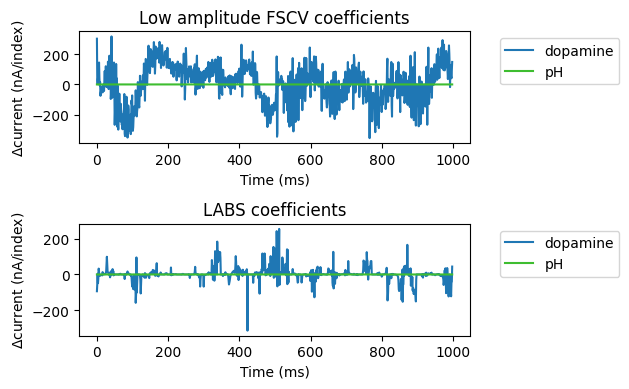

In [28]:
# compare betas
# Plot coefficients
low_FSCV_betas = cvglmnetCoef(low_FSCV_cvFit, 'lambda_min')
LABS_betas = cvglmnetCoef(LABS_cvFit, 'lambda_min')
c_analyte = ['#1f77b4','#871fb4','#3ebd30']# colors for each analyte
fig,ax = plt.subplots(2,1,dpi=100,figsize=(7,4))

for i in [0,2]:
    ax[0].plot(np.squeeze(low_FSCV_betas[i])[1::],color=c_analyte[i])
ax[0].set_title('Low amplitude FSCV coefficients')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel(r'$\Delta$current (nA/index)')
ax[0].legend({'dopamine','pH'},loc='upper right', bbox_to_anchor=(0.9, 0.5,0.5,0.5))
        
for j in [0,2]:
    ax[1].plot(np.squeeze(LABS_betas[j])[1::],color=c_analyte[j])
ax[1].set_title('LABS coefficients')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel(r'$\Delta$current (nA/index)')
plt.legend({'dopamine','pH'},loc='upper right', bbox_to_anchor=(0.9, 0.5,0.5,0.5));

plt.tight_layout()   


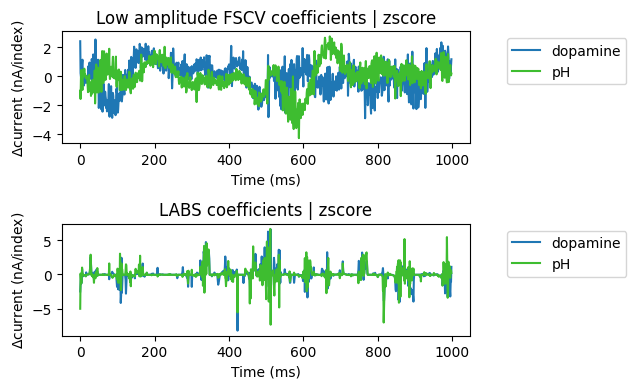

In [9]:
from scipy import stats as STATS
fig,ax = plt.subplots(2,1,dpi=100,figsize=(7,4))

for i in [0,2]:
    ax[0].plot(STATS.zscore(np.squeeze(low_FSCV_betas[i])[1::]),color=c_analyte[i])
ax[0].set_title('Low amplitude FSCV coefficients | zscore')
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel(r'$\Delta$current (nA/index)')
ax[0].legend({'dopamine','pH'},loc='upper right', bbox_to_anchor=(0.9, 0.5,0.5,0.5))
        
for j in [0,2]:
    ax[1].plot(STATS.zscore(np.squeeze(LABS_betas[j])[1::]),color=c_analyte[j])
ax[1].set_title('LABS coefficients | zscore')
ax[1].set_xlabel('Time (ms)')
ax[1].set_ylabel(r'$\Delta$current (nA/index)')
plt.legend({'dopamine','pH'},loc='upper right', bbox_to_anchor=(0.9, 0.5,0.5,0.5));

plt.tight_layout()   



In [10]:
## Credits
import sys, platform, time
print('This data demo was created using:')
print('Python Version:',sys.version)
print('Operating System:',platform.system(),'Version',platform.release())
print('GLMnet for python: https://web.stanford.edu/~hastie/glmnet_python/')
print('Numpy: https://numpy.org/')
print('h5py: http://www.h5py.org/')
print('pyplot: https://matplotlib.org/index.html')
print('sklearn: https://scikit-learn.org/stable/')
print('recordclass: https://pypi.org/project/recordclass/')
print('Last updated:',time.strftime('%d-%b-%Y %H:%M:%S',time.localtime()))

This data demo was created using:
Python Version: 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Operating System: Darwin Version 18.7.0
GLMnet for python: https://web.stanford.edu/~hastie/glmnet_python/
Numpy: https://numpy.org/
h5py: http://www.h5py.org/
pyplot: https://matplotlib.org/index.html
sklearn: https://scikit-learn.org/stable/
recordclass: https://pypi.org/project/recordclass/
Last updated: 04-Jan-2021 12:50:59
